In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
from scipy.signal import detrend
from datetime import datetime


In [2]:
def fetch_mhw_data(lon0, lat0, lon1, lat1, start, end):
    url = f"https://eco.odb.ntu.edu.tw/api/mhw"
    params = {
        "lon0": lon0,
        "lat0": lat0,
        "lon1": lon1,
        "lat1": lat1,
        "start": start,
        "end": end,
        "append": "sst,sst_anomaly,level",
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    else:
        print("Failed to fetch data:", response.text)
        return None

# Fetch data year by year for the Mediterranean region
def fetch_yearly_data(lon0, lat0, lon1, lat1, start_year, end_year):
    all_data = []
    for year in range(start_year, end_year + 1):
        start = f"{year}-01-01"
        end = f"{year}-12-31"
        print(f"Fetching data for {start} to {end}...")
        yearly_data = fetch_mhw_data(lon0, lat0, lon1, lat1, start, end)
        if yearly_data is not None:
            all_data.append(yearly_data)
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return None

# Function to remove the seasonal cycle
def remove_seasonal_cycle(data, variable):
    # Ensure 'date' is a datetime object and extract the month
    data = data.copy()  # Avoid SettingWithCopyWarning by working on a copy
    data['month'] = data['date'].dt.month  # Extract the month for grouping
    
    # Calculate monthly climatology for the given variable (e.g., 'sst_anomaly')
    monthly_climatology = data.groupby('month')[variable].mean()
    # print(monthly_climatology)
    
    # Remove the seasonal cycle by subtracting the monthly climatology
    data[f'{variable}_deseasonalized'] = data.apply(
        lambda row: row[variable] - monthly_climatology[row['month']],
        axis=1
    )
    
    return data      

In [3]:
# Step 2: Fetch data for the Mediterranean region
lon0, lat0, lon1, lat1 = -5, 30, 36, 46  # Region bounds
start, end = "1982-01-01", "2024-10-01"  # Time range
data = fetch_mhw_data(lon0, lat0, lon1, lat1, start, end)
print(data)

           lon     lat        date  level       sst  sst_anomaly
0       -4.875  30.125  1982-01-01      0       NaN          NaN
1       -4.625  30.125  1982-01-01      0       NaN          NaN
2       -4.375  30.125  1982-01-01      0       NaN          NaN
3       -4.125  30.125  1982-01-01      0       NaN          NaN
4       -3.875  30.125  1982-01-01      0       NaN          NaN
...        ...     ...         ...    ...       ...          ...
125947  34.875  45.875  1982-12-01      0  5.823225      -0.4053
125948  35.125  45.875  1982-12-01      0  5.970645      -0.3278
125949  35.375  45.875  1982-12-01      0  6.262580      -0.1232
125950  35.625  45.875  1982-12-01      0  6.467741       0.0132
125951  35.875  45.875  1982-12-01      0  6.588387       0.1030

[125952 rows x 6 columns]


In [4]:
start_year, end_year = 1982, 2024  # Year range
data = fetch_yearly_data(lon0, lat0, lon1, lat1, start_year, end_year)
print(data)

Fetching data for 1982-01-01 to 1982-12-31...
Fetching data for 1983-01-01 to 1983-12-31...
Fetching data for 1984-01-01 to 1984-12-31...
Fetching data for 1985-01-01 to 1985-12-31...
Fetching data for 1986-01-01 to 1986-12-31...
Fetching data for 1987-01-01 to 1987-12-31...
Fetching data for 1988-01-01 to 1988-12-31...
Fetching data for 1989-01-01 to 1989-12-31...
Fetching data for 1990-01-01 to 1990-12-31...
Fetching data for 1991-01-01 to 1991-12-31...
Fetching data for 1992-01-01 to 1992-12-31...
Fetching data for 1993-01-01 to 1993-12-31...
Fetching data for 1994-01-01 to 1994-12-31...
Fetching data for 1995-01-01 to 1995-12-31...
Fetching data for 1996-01-01 to 1996-12-31...
Fetching data for 1997-01-01 to 1997-12-31...
Fetching data for 1998-01-01 to 1998-12-31...
Fetching data for 1999-01-01 to 1999-12-31...
Fetching data for 2000-01-01 to 2000-12-31...
Fetching data for 2001-01-01 to 2001-12-31...
Fetching data for 2002-01-01 to 2002-12-31...
Fetching data for 2003-01-01 to 20

In [78]:
if data is not None:
    # Step 2: Process data
    data["date"] = pd.to_datetime(data["date"])
    data = data.sort_values("date")
    
    # Group by grid point and detrend each time series
    detrended_data = []
    for (lon, lat), group in data.groupby(["lon", "lat"]):
        group = group.sort_values("date")
        
        # Drop rows with NaN values in 'sst_anomaly'
        group = group.dropna(subset=["sst_anomaly"])
        
        # Only detrend if there's enough data after dropping NaNs
        if len(group) > 1:
            group["sst_anomaly_detrended"] = detrend(group["sst_anomaly"], type="linear")
        else:
            group["sst_anomaly_detrended"] = np.nan  # Not enough data to detrend
        
        detrended_data.append(group)
    
    detrended_data = pd.concat(detrended_data)
else:
    print("No data fetched. Please check the API calls.")

In [79]:
# Step 3: Reshape data into a grid for plotting 
def reshape_to_grid_fixed(data, column, date):
    # Filter data for the given date
    data_filtered = data[data["date"] == date]
    
    # Create full lat/lon grid based on unique values
    all_lats = np.sort(data["lat"].unique())
    all_lons = np.sort(data["lon"].unique())
    
    # Create a DataFrame for the full grid
    grid = pd.DataFrame(index=all_lats, columns=all_lons)
    
    # Populate the grid with data
    for _, row in data_filtered.iterrows():
        grid.at[row["lat"], row["lon"]] = row[column]
    
    # Convert to float for plotting
    return grid.astype(float)

In [80]:
# Select a specific date for visualization
date_to_plot = "2022-07-01"
sst_anomaly_grid = reshape_to_grid_fixed(data, "sst_anomaly", date_to_plot)
detrended_grid = reshape_to_grid_fixed(detrended_data, "sst_anomaly_detrended", date_to_plot)

# Print the grid and specific region for debugging
# print("Fixed grid shape:", sst_anomaly_grid.shape)
# print(sst_anomaly_grid.loc[38:42, 5:8])  # Focus on the blue-box region

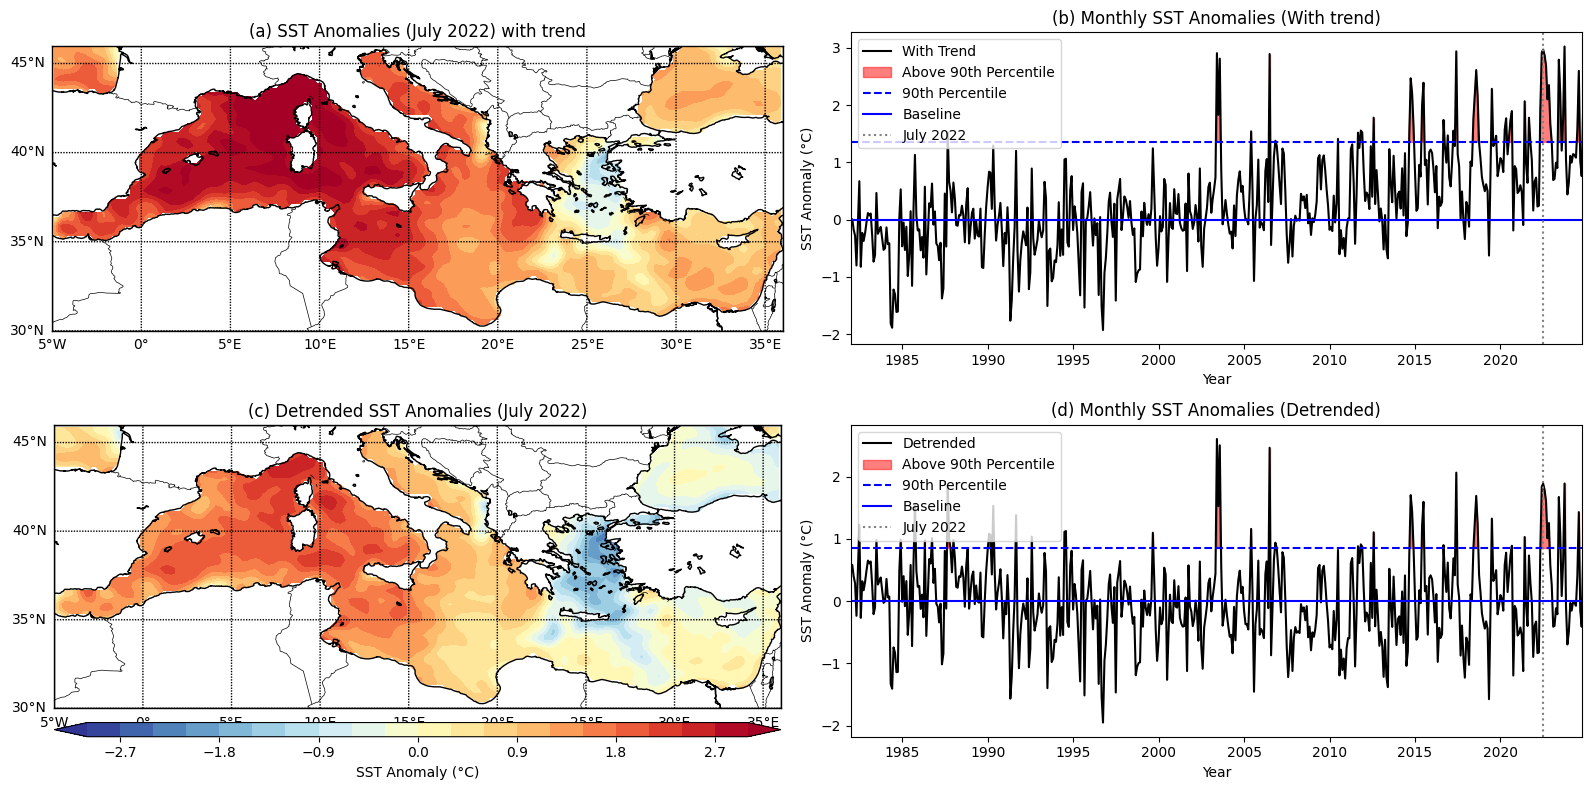

In [81]:
# Initialize figure
plt.figure(figsize=(16, 8))

# Plot SST anomalies with trend (upper-left)
plt.subplot(2, 2, 1)
m = Basemap(projection="cyl", llcrnrlon=lon0, llcrnrlat=lat0, urcrnrlon=lon1, urcrnrlat=lat1, resolution="i")
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(lat0, lat1 + 1, 5), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(lon0, lon1 + 1, 5), labels=[0, 0, 0, 1])
# Ensure lon and lat match the grid dimensions
lon, lat = np.meshgrid(sst_anomaly_grid.columns, sst_anomaly_grid.index)
# lon, lat = lon[:sst_anomaly_grid.shape[0], :sst_anomaly_grid.shape[1]], lat[:sst_anomaly_grid.shape[0], :sst_anomaly_grid.shape[1]]

m.drawmapboundary(fill_color='white') 
cs = m.contourf(lon, lat, sst_anomaly_grid.values, 
                cmap=cm.RdYlBu_r, 
                levels=np.linspace(-3, 3, 21),
                extend='both',
                latlon=True)

# cbar = m.colorbar(cs, location="right", pad="5%")
# cbar.set_label("SST Anomaly (°C)")
plt.title("(a) SST Anomalies (July 2022) with trend")

# Plot detrended SST anomalies (lower-left)
plt.subplot(2, 2, 3)
m = Basemap(projection="cyl", llcrnrlon=lon0, llcrnrlat=lat0, urcrnrlon=lon1, urcrnrlat=lat1, resolution="i")
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(lat0, lat1 + 1, 5), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(lon0, lon1 + 1, 5), labels=[0, 0, 0, 1])
# Ensure lon and lat match the grid dimensions
lon, lat = np.meshgrid(detrended_grid.columns, detrended_grid.index)
# lon, lat = lon[:detrended_grid.shape[0], :detrended_grid.shape[1]], lat[:detrended_grid.shape[0], :detrended_grid.shape[1]]

m.drawmapboundary(fill_color='white') 
cs = m.contourf(lon, lat, detrended_grid.values, 
                cmap=cm.RdYlBu_r, 
                levels=np.linspace(-3, 3, 21),
                extend='both',
                latlon=True)

cbar = m.colorbar(cs, location="bottom", pad="5%")
cbar.set_label("SST Anomaly (°C)")
plt.title("(c) Detrended SST Anomalies (July 2022)")

# Adjust bounds for time-series (smaller region near coast)
# Step 1: Filter data for the smaller region near the coast
time_series_lon0, time_series_lat0, time_series_lon1, time_series_lat1 = 0, 40, 12, 44
regional_data = data[
    (data["lat"] >= time_series_lat0) & 
    (data["lat"] <= time_series_lat1) & 
    (data["lon"] >= time_series_lon0) & 
    (data["lon"] <= time_series_lon1)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Step 2: Remove the seasonal cycle for the smaller region
# regional_data = remove_seasonal_cycle(regional_data, 'sst_anomaly')

# Step 3: Compute the regional average for time-series plots
# With trend
# regional_mean_with_trend = regional_data.groupby("date")["sst_anomaly_deseasonalized"].mean()
# Step 3: Compute the regional average for time-series plots
regional_mean_with_trend = regional_data.groupby("date")["sst_anomaly"].mean()

# Without trend (detrended)
regional_detrended_data = detrended_data[
    (detrended_data["lat"] >= time_series_lat0) & 
    (detrended_data["lat"] <= time_series_lat1) & 
    (detrended_data["lon"] >= time_series_lon0) & 
    (detrended_data["lon"] <= time_series_lon1)
].copy()  # Use .copy() to avoid SettingWithCopyWarning
# regional_detrended_data = remove_seasonal_cycle(regional_detrended_data, 'sst_anomaly_detrended')
# regional_mean_detrended = regional_detrended_data.groupby("date")["sst_anomaly_detrended_deseasonalized"].mean()
regional_mean_detrended = regional_detrended_data.groupby("date")["sst_anomaly_detrended"].mean()

# Step 4: Plot time-series SST anomalies
# Compute 90th percentiles
percentile_90_with_trend = np.percentile(regional_mean_with_trend.values, 90)
percentile_90_detrended = np.percentile(regional_mean_detrended.values, 90)

# Step 4: Plot time-series SST anomalies with proper highlighting
# Define the date range explicitly for the x-axis
x_min = datetime(1982, 1, 1)  # Jan, 1982
x_max = datetime(2024, 10, 1)  # Oct, 2024

# Define the vertical line date
vertical_line_date = datetime(2022, 7, 1)  # July, 2022

plt.subplot(2, 2, 2)
plt.plot(
    regional_mean_with_trend.index,
    regional_mean_with_trend.values,
    label="With Trend",
    color="black",
)
plt.xlim([x_min, x_max])
# Highlight values above the 90th percentile in red (only above the line)
plt.fill_between(
    regional_mean_with_trend.index,
    percentile_90_with_trend,  # Lower bound (90th percentile line)
    regional_mean_with_trend.values,  # Upper bound (data)
    where=regional_mean_with_trend.values > percentile_90_with_trend,
    color="red",
    alpha=0.5,
    label="Above 90th Percentile",
)
plt.axhline(y=percentile_90_with_trend, color="blue", linestyle="--", label="90th Percentile")
plt.axhline(y=0, color="blue", label="Baseline")
plt.axvline(x=vertical_line_date, color="gray", linestyle="dotted", label="July 2022")
plt.title("(b) Monthly SST Anomalies (With trend)")
plt.ylabel("SST Anomaly (°C)")
plt.xlabel("Year")
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(
    regional_mean_detrended.index,
    regional_mean_detrended.values,
    label="Detrended",
    color="black",
)
plt.xlim([x_min, x_max])
# Highlight values above the 90th percentile in red (only above the line)
plt.fill_between(
    regional_mean_detrended.index,
    percentile_90_detrended,  # Lower bound (90th percentile line)
    regional_mean_detrended.values,  # Upper bound (data)
    where=regional_mean_detrended.values > percentile_90_detrended,
    color="red",
    alpha=0.5,
    label="Above 90th Percentile",
)
plt.axhline(y=percentile_90_detrended, color="blue", linestyle="--", label="90th Percentile")
plt.axhline(y=0, color="blue", label="Baseline")
plt.axvline(x=vertical_line_date, color="gray", linestyle="dotted", label="July 2022")
plt.title("(d) Monthly SST Anomalies (Detrended)")
plt.ylabel("SST Anomaly (°C)")
plt.xlabel("Year")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()